#### <strong>第三次作品：分類器的原理與評比實驗(資料三)</strong>
學號：410978002

姓名：謝元皓

<font color=skyblue>作品描述</font>：
 
本專題計畫執行這篇講義描述的分類器比較，即採用三種分類器分別對三組資料進行分類學習與測試。
其中分類器包括

- 多元羅吉斯回歸 (Multinomial Logistic Regression)
- 支援向量機 (Support Vector Machine)
- 神經網路 (Neural Network)

此作業包含共三筆資料，分成三份檔案呈現，每份資料分別運用三種分類器進行分類學習與測試。

<font color=skyblue>資料描述</font>：
第三筆為來自 Yale Face 38 人的人臉影像共 2410 張，每張大小 192×168。
 <hr>

### 資料讀取
- 將資料拆成分成訓練資料跟測試資料。
- 訓練和測試資料比例為 $4:1$。
- 先將原始資料標準化(必須將訓練和測試資料分開標準化)。
- 再運用PCA降維創造出主成分資料。
- 順便列印出訓練資料跟測試資料的大小。

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io
import os

D = scipy.io.loadmat('allFaces.mat')
X = D['faces'].T # 32256 x 2410, each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = D['m'].item() # 168
n = D['n'].item() # 192
n_persons = D['person'].item() # 38

y_labels = np.repeat(np.arange(len(y)), y)
# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 主成分分析 (PCA)
proportion = 0.8
pca = PCA(proportion)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape) 
print(X_train_pca.shape)
print(X_test_pca.shape)




(1928, 32256) (1928,)
(482, 32256) (482,)
(1928, 7)
(482, 7)


## 分類器一: 多元邏吉斯回歸
- 需使用套件 sklearn 中的 LogisticRegression
- 運用Cross validation 的方式，找出最佳參數。
- 需使用到sklearn 中 GridSearchCV套件。
- 找出最好參數後，再用此訓練及測試資料。
<hr> 


### step1 運用 Cross validation 的方式，找出最佳的參數
#### 套件介紹
1. LogisticRegression 為Scikit-learn庫中的Logistic Regression模型
2. GridSearchCV, StratifiedShuffleSpli 為 Scikit-learn庫中的網格搜索(GridSearchCV)和分層洗牌分割(StratifiedShuffleSplit)模組。網格搜索用於選擇最佳的超參數，分層洗牌分割用於交叉驗證。

### 程式碼解析
這段程式碼使用了 scikit-learn 中的 LogisticRegression 和 GridSearchCV 來進行邏輯回歸模型的超參數調校和交叉驗證。我來解釋一下程式碼的各個部分：

1. **匯入庫**：
   ```python
   from sklearn.linear_model import LogisticRegression
   from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
   ```
   匯入了 scikit-learn 中的 LogisticRegression 類別和 GridSearchCV、StratifiedShuffleSplit 類別。

2. **定義參數**：
   ```python
   opts = dict(tol=1e-3, max_iter=int(1e3))
   ```
   設置了 LogisticRegression 的參數，包括收斂容忍度(tol)和最大迭代次數(max_iter)。

3. **定義參數網格**：
   ```python
   parameters = {'solver': ['lbfgs', 'liblinear', 'newton-cg'], 'C': [0.1, 1, 10]}
   ```
   設置了要調校的超參數網格，包括 solver 和 C。

4. **定義交叉驗證策略**：
   ```python
   cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
   ```
   使用 StratifiedShuffleSplit 來定義交叉驗證策略，其中包括了 5 折交叉驗證，訓練集測試集比例為 0.2，並且設置了隨機種子。

5. **建立 GridSearchCV 物件**：
   ```python
   grid = GridSearchCV(estimator=LogisticRegression(**opts), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")
   ```
   使用 GridSearchCV 來建立一個網格搜尋物件，其中包括了 LogisticRegression 作為基礎估計器，設置了要調校的參數網格、交叉驗證策略、評估指標為準確率和 f1_macro，並且設置了 refit 為準確率，意味著將根據準確率來重新擬合最佳模型。

6. **進行模型訓練與評估**：
   ```python
   grid.fit(X_train, y_train)
   ```
   使用訓練數據 X_train 和 y_train 來進行模型訓練和參數調校。

7. **查看最佳結果**：
   ```python
   print(grid.best_params_)
   print(grid.best_score_)
   print(grid.best_estimator_)
   ```
   輸出網格搜尋後得到的最佳參數、最佳分數以及最佳估計器（最佳模型）。

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

opts = dict(tol = 1e-3, max_iter = int(1e3)) # parameters for LogisticRegression
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg'], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=LogisticRegression(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)



<結果與討論>
- 試跑過上述程式，直行約一整晚沒有結果。
- 改用預設參數訓練及測試資料。

### step2 測試資料之準確率回報
- 運用上一步找出最佳參數訓練資料，計算各項準確率

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# 初始化羅吉斯回歸分類器並使用上一步找出的最佳參數
logreg = LogisticRegression(C=1, solver='lbfgs',tol = 1e-6, max_iter = int(1e6), verbose=1)

# 使用原始資料進行訓練及測試
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
accuracy_orig = accuracy_score(y_test, y_pred)

# 使用主成分資料進行訓練及測試
logreg.fit(X_train_pca, y_train)
y_pred_pca = logreg.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print("Accuracy using original data:", accuracy_orig)
print("Accuracy using principal components:", accuracy_pca)

Accuracy using original data: 0.9688796680497925
Accuracy using principal components: 0.3630705394190871


< 結果與討論 >
- 上述這段程式碼將使用原始資料和使用PCA降維後的主成分資料來訓練和測試多元羅吉斯回歸分類器。
- 它會列印出兩種情況下的準確率(原始資料的準確率為96.88%，主成分(n = 7)後的資料準確率為36.3%)
<hr>

## 分類器二: 支援向量機 (Support Vector Machine)
### step1 運用 Cross validation 的方式，找出最佳的參數
#### 套件介紹
1. SVC 是 Scikit-learn 中的支持向量機分類器，
2. GridSearchCV 是用於超參數優化的網格搜索類別，
3. StratifiedShuffleSplit 用於生成分層隨機分割的交叉驗證集，
4. datetime 是 Python 的日期和時間處理類別，
5. pandas 是 Python 中用於數據處理的庫。

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit
opts = dict(tol = 1e-3, max_iter = int(1e3)) # parameters for LogisticRegression
parameters = {'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=SVC(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

<結果與討論>
- 試跑過上述程式，直行約一整晚沒有結果。
- 改用預設參數訓練及測試資料。
<hr>

### step2 測試資料之準確率回報
- 運用上一步找出最佳參數練資料，同時計算各項準確率

#### 程式碼解析
這段程式碼演示了如何使用 Scikit-learn 中的支持向量機 (SVM) 來進行分類任務，並使用 `classification_report` 函數生成分類報告。讓我們一步步來解釋它：

1. **導入必要的庫和類別**：
   ```python
   from sklearn.svm import SVC, LinearSVC
   from sklearn.metrics import classification_report
   ```
   這些語句導入了必要的庫和類別。`SVC` 是 Scikit-learn 中的支持向量機分類器，`LinearSVC` 是用於線性支持向量機的類別，`classification_report` 是用於生成分類報告的函數。

2. **設置模型參數**：
   ```python
   C = 0.1  # SVM regularization parameter
   opts = dict(C=C, tol=1e-6, max_iter=int(1e6))
   ```
   這裡設置了一個正則化參數 `C`，以及一些其他的 SVC 參數，如容忍度 `tol` 和最大迭代次數 `max_iter`。這些參數將用於初始化 SVC 分類器。

3. **初始化 SVC 分類器**：
   ```python
   clf_svm = SVC(kernel='linear', **opts)
   ```
   這行程式碼初始化了一個 SVC 分類器。`kernel` 參數指定了要使用的核函數，這裡使用線性核函數 ('linear')。`**opts` 將之前設置的參數傳遞給 SVC 分類器。

4. **模型訓練**：
   ```python
   clf_svm.fit(X_train, y_train)
   ```
   這行程式碼使用訓練集 `X_train` 和對應的標籤 `y_train` 來訓練 SVC 分類器。

5. **進行預測**：
   ```python
   predictions = clf_svm.predict(X_test)
   ```
   這行程式碼使用訓練好的 SVC 分類器對測試集 `X_test` 進行預測，並將預測結果存儲在 `predictions` 變量中。

6. **生成分類報告**：
   ```python
   print(classification_report(y_test, predictions))
   ```
   這行程式碼使用 `classification_report` 函數生成一個分類報告，該報告包含了精度、召回率、F1 值等指標，用於評估模型的性能。`y_test` 是測試集的真實標籤，`predictions` 是模型的預測結果。

In [5]:
#原始資料標準化後的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 0.1 # SVM regularization parameter
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='linear', **opts)
clf_svm.fit(X_train_scaled, y_train)
predictions = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.73      0.80      0.76        10
           2       0.79      1.00      0.88        11
           3       0.94      1.00      0.97        16
           4       0.75      0.60      0.67         5
           5       0.93      1.00      0.96        13
           6       0.95      1.00      0.97        19
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        14
           9       0.88      0.88      0.88         8
          10       0.93      0.93      0.93        14
          11       1.00      0.94      0.97        16
          12       0.78      0.78      0.78         9
          13       0.92      1.00      0.96        12
          14       0.81      1.00      0.90        13
          15       1.00      0.83      0.91        12
          16       1.00      1.00      1.00        14
          17       1.00    

In [6]:
# 主成分資料的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 0.1 # SVM regularization parameter
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='linear', **opts)
clf_svm.fit(X_train_pca, y_train)
predictions = clf_svm.predict(X_test_pca)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38        22
           1       0.14      0.20      0.17        10
           2       0.40      0.55      0.46        11
           3       0.39      0.56      0.46        16
           4       0.18      0.40      0.25         5
           5       0.43      0.46      0.44        13
           6       0.70      0.37      0.48        19
           7       0.39      0.70      0.50        10
           8       0.20      0.14      0.17        14
           9       0.33      0.50      0.40         8
          10       0.40      0.57      0.47        14
          11       0.44      0.44      0.44        16
          12       0.36      0.56      0.43         9
          13       0.40      0.33      0.36        12
          14       0.35      0.46      0.40        13
          15       0.44      0.33      0.38        12
          16       0.17      0.07      0.10        14
          17       0.16    

c:\Users\W9H40\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#### 各項指標的描述 
這是分類報告，用於評估支持向量機 (SVM) 分類器在測試集上的性能。以下是報告中各個指標的解釋：

1. **precision**（精度）：指的是在所有被分類為某類的樣本中，真正屬於該類別的樣本所占的比例。比如對類別1而言，精度為0.95，意味著有95%的真正屬於類別1的樣本被成功地分類為類別1。

2. **recall**（召回率）：指的是在所有真正屬於某類的樣本中，被正確分類為該類別的樣本所占的比例。比如對類別2而言，召回率為0.73，意味著有73%的真正屬於類別2的樣本被成功地分類為類別。

3. **f1-score**（F1 值）：精度和召回率的加權調和平均值，是一個綜合考慮精度和召回率的指標。F1 值越高，模型的性能越好。

4. **support**（支援度）：每個類別在測試集中的樣本數量。

5. **accuracy**（準確率）：模型在測試集上的整體準確率，即所有正確預測的樣本數佔所有樣本數的比例。

6. **macro avg**（宏平均）：對所有類別的精度、召回率和 F1 值進行算術平均。它對每個類別的性能給予相同的權重，不考慮類別不平衡的問題。

7. **weighted avg**（加權平均）：對所有類別的精度、召回率和 F1 值進行加權平均，權重為每個類別的支援度（樣本數量）。這反映了不同類別在測試集中的重要性。
<hr>

## 分類器三: 神經網路 (Neural Network)
### step 1 **一樣先執行cross validation**
這段程式碼是用來進行 MLPClassifier 的參數調優。逐行解釋：

1. `from sklearn.neural_network import MLPClassifier`: 從 Scikit-Learn 中導入 MLPClassifier，這是一個多層感知機分類器，用於進行神經網路相關的分類任務。

2. `from sklearn.model_selection import GridSearchCV`: 從 Scikit-Learn 中導入 GridSearchCV，用於進行參數的網格搜索和交叉驗證。

3. `opts = dict(tol=1e-6, max_iter=int(1e6))`: 創建了一個字典 `opts`，其中包含了 MLPClassifier 的一些參數設置，例如 `tol`（容忍度）和 `max_iter`（最大迭代次數）。

4. `param_grid`: 定義了一個參數網格，包含了我們想要調優的參數及其可能的取值範圍。這些參數包括隱藏層大小、激活函數、求解器和 alpha（正則化參數）。

5. `cv`: 定義了交叉驗證的策略。在這裡，使用了 StratifiedShuffleSplit，它會將數據集分成 5 個子集，每個子集都保持類別分佈的一致性，並且使用 20% 的數據作為測試集。

6. `grid = GridSearchCV(estimator=MLPClassifier(**opts), param_grid=param_grid, cv=cv, scoring=['accuracy', 'f1_macro'], refit="accuracy")`: 初始化了一個 GridSearchCV 對象，指定了要搜索的模型（MLPClassifier），參數網格，交叉驗證策略，評估指標（這裡使用了 accuracy 和 f1_macro），以及要根據哪個指標來選擇最佳模型（在這裡是 accuracy）。

7. `grid.fit(X_train_scaled, y_train)`: 調用 GridSearchCV 對象的 fit 方法，開始在訓練集上進行參數搜索和交叉驗證。

8. `print(grid.best_params_)`: 打印出搜索過程中得到的最佳參數組合。

9. `print(grid.best_score_)`: 打印出使用最佳參數組合在交叉驗證中獲得的最佳得分。

10. `print(grid.best_estimator_)`: 打印出具有最佳參數的最佳估算器（即最佳模型）的詳細信息。

總的來說，這段程式碼是一個完整的參數調優流程，通過網格搜索和交叉驗證，找到了 MLPClassifier 的最佳參數組合，以提高其在給定數據集上的性能。

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
opts = dict(tol = 1e-6, max_iter = int(1e6)) 
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=MLPClassifier(**opts), \
                param_grid=param_grid, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

<結果與討論>
- 試跑過上述程式，執行約一整晚沒有結果。
- 改用預設參數訓練及測試資料。

### 程式碼解析
這段程式碼使用了Scikit-learn中的MLPClassifier來建立一個多層感知器（MLP）分類模型，並使用該模型對測試數據進行預測，最後印出分類報告。

讓我們一步步解釋這段程式碼：

1. `from sklearn.neural_network import MLPClassifier`: 導入MLPClassifier類別，該類別實現了多層感知器分類器，用於構建和訓練MLP模型。

2. `from sklearn.metrics import classification_report`: 導入classification_report函數，該函數用於生成分類模型的分類報告，其中包含準確率、召回率、F1分數等指標。

3. `hidden_layers = (30,)` 和 `activation = 'logistic'`: 這裡指定了MLP模型的一些參數，包括隱藏層的大小和激活函數。在這個例子中，隱藏層只有30個單元，激活函數為logistic。

4. `opts = dict(hidden_layer_sizes=hidden_layers, verbose=True, activation=activation, tol=1e-6, max_iter=int(1e6))`: 定義了一個字典opts，其中包含了MLPClassifier的參數設置。這些參數包括隱藏層的大小、是否打印訓練信息、激活函數、容忍誤差以及最大迭代次數等。

5. `solver = 'adam'`: 指定了MLP模型的優化器為adam。adam是一種常用的優化算法，通常在深度學習中表現良好。

6. `clf_MLP = MLPClassifier(solver=solver, **opts)`: 通過MLPClassifier類別創建了一個MLP分類器，並傳入了solver參數以及opts字典中的其他參數。

7. `clf_MLP.fit(X_train_scaled, y_train)`: 使用訓練數據X_train_scaled和標籤y_train來訓練MLP模型。

8. `predictions = clf_MLP.predict(X_test_scaled)`: 使用訓練好的模型對測試數據X_test_scaled進行預測，並將預測結果保存在predictions變量中。

9. `print(classification_report(y_test, predictions))`: 印出分類報告，其中包含了模型在測試數據上的準確率、召回率、F1分數等評估指標。

In [9]:
#原始資料標準化
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
# hidden_layers = (512,) # one hidden layer
# activation = ’relu’ # the default
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = True, \
activation = activation, tol = 1e-3, max_iter = int(1e3))
solver = 'adam' # default solver
clf_MLP = MLPClassifier(solver = solver, **opts)
clf_MLP.fit(X_train_scaled, y_train)
predictions = clf_MLP.predict(X_test_scaled)
print(classification_report(y_test, predictions))

Iteration 1, loss = 3.64319965
Iteration 2, loss = 3.54765900
Iteration 3, loss = 3.49198809
Iteration 4, loss = 3.43729481
Iteration 5, loss = 3.36159762
Iteration 6, loss = 3.27215046
Iteration 7, loss = 3.19420647
Iteration 8, loss = 3.10147534
Iteration 9, loss = 3.01172107
Iteration 10, loss = 2.89128738
Iteration 11, loss = 2.80600540
Iteration 12, loss = 2.70661404
Iteration 13, loss = 2.60029344
Iteration 14, loss = 2.50891366
Iteration 15, loss = 2.41386389
Iteration 16, loss = 2.31933274
Iteration 17, loss = 2.22154302
Iteration 18, loss = 2.11845942
Iteration 19, loss = 2.04248446
Iteration 20, loss = 1.95215152
Iteration 21, loss = 1.87605080
Iteration 22, loss = 1.80808720
Iteration 23, loss = 1.73274810
Iteration 24, loss = 1.68232123
Iteration 25, loss = 1.59497367
Iteration 26, loss = 1.52294851
Iteration 27, loss = 1.47003857
Iteration 28, loss = 1.38553878
Iteration 29, loss = 1.31585134
Iteration 30, loss = 1.27108981
Iteration 31, loss = 1.20985500
Iteration 32, los

### 輸出內容解析

這段程式輸出了一系列迭代次數和損失值。這個程式可能是一個訓練過程的一部分，通常是在機器學習或深度學習中使用。這裡的「loss」代表了模型在每個迭代中的損失值，損失值通常用來衡量模型預測和實際值之間的差異。

這些迭代和損失值給了我們一個了解模型訓練過程的指標。在迭代的早期，損失值相對較高，逐漸降低直到穩定。這是因為模型通過梯度下降等優化算法逐步調整參數以最小化損失值。

在這個例子中，隨著迭代次數的增加，損失值從3.64逐漸降低到1.59。這可能表示模型的性能不斷改善，損失越來越小，模型對於訓練數據的擬合越來越好。

接下來的輸出可能是模型在測試數據上的表現評估結果。準確率、精確率、召回率和F1值等指標提供了對模型在不同類別上表現的評價。在這個例子中，總體準確率為0.93，這意味著模型在測試數據上的表現相當不錯。

總的來說，這段程式展示了一個訓練過程的動態，從損失值的改善到最終的模型性能評估。
<hr>

 #### **畫出測試資料的confusion matrix**
這段程式碼使用了Scikit-learn中的ConfusionMatrixDisplay模組和Matplotlib來繪製混淆矩陣。讓我們一步步解釋：

1. `from sklearn.metrics import ConfusionMatrixDisplay`: 導入ConfusionMatrixDisplay模組，該模組提供了一個便捷的方法來可視化混淆矩陣。

2. `import matplotlib.pyplot as plt`: 導入Matplotlib庫，用於繪製圖表。

3. `fig, ax = plt.subplots(1, 1, figsize=(12,12))`: 創建一個12x12大小的子圖，用於顯示混淆矩陣。

4. `score = 100*clf_MLP.score(X_test_scaled, y_test)`: 使用MLP模型的score方法計算測試數據的準確率，並將其轉換為百分比形式。

5. `title = 'Testing score ={:.2f}%'.format(score)`: 根據測試準確率創建標題，並將準確率插入標題字符串中。

6. `disp = ConfusionMatrixDisplay.from_estimator`: 使用ConfusionMatrixDisplay模組的from_estimator方法來創建混淆矩陣的可視化。它需要以下參數：
   - `clf_MLP`: 要評估的分類器（MLP模型）。
   - `X_test_scaled`: 測試數據。
   - `y_test`: 測試數據的真實標籤。
   - `xticks_rotation=45`: x軸刻度標籤的旋轉角度，這裡設置為45度。
   - `cmap=plt.cm.Blues`: 顏色映射，用於設置混淆矩陣的顏色。
   - `normalize='true'`: 是否對混淆矩陣進行正規化，這裡設置為true，表示對每一行進行正規化。
   - `ax=ax`: 指定子圖來繪製混淆矩陣。

7. `disp.ax_.set_title(title)`: 設置子圖的標題為剛剛創建的標題字符串。

8. `plt.show()`: 顯示混淆矩陣圖表。

總的來說，這段程式碼用於創建並顯示測試數據的混淆矩陣，並在圖表中包含了測試準確率的信息。

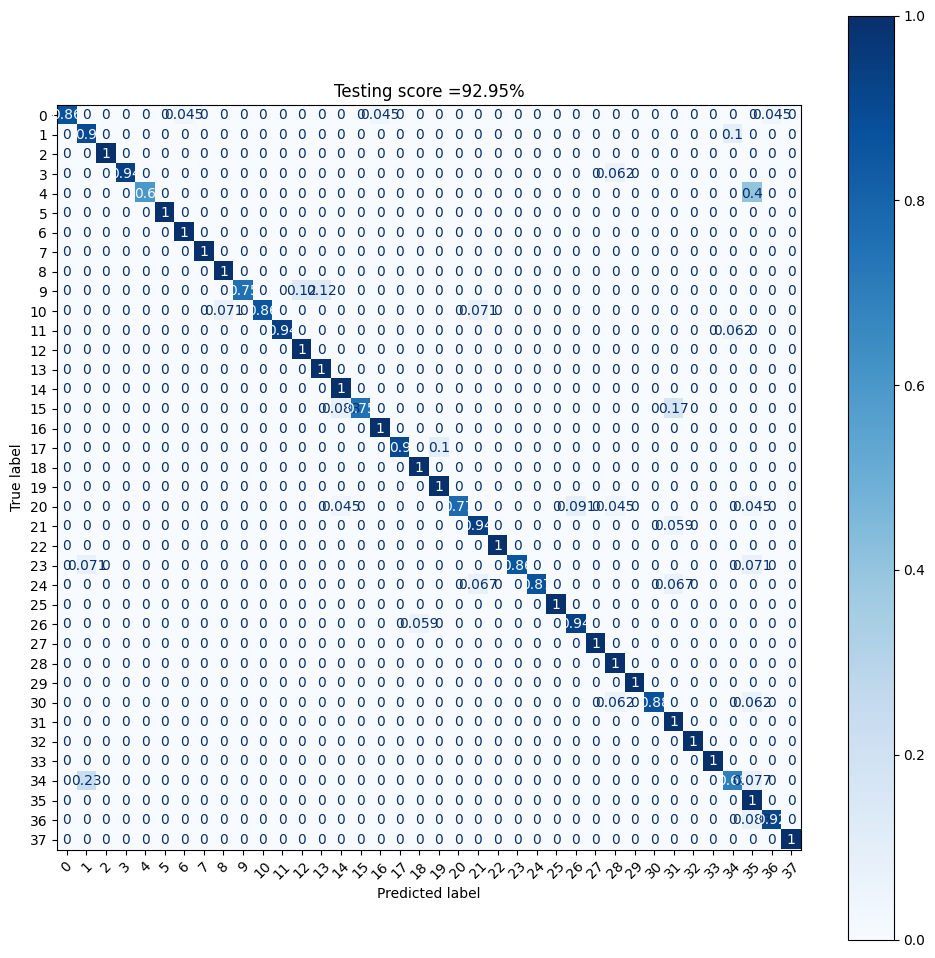

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12,12))
score = 100*clf_MLP.score(X_test_scaled, y_test)
title = 'Testing score ={:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
clf_MLP,
X_test_scaled,
y_test,
xticks_rotation=45, #’vertical’,
# display_labels=class_names,
cmap=plt.cm.Blues,
normalize='true',
ax = ax
)
disp.ax_.set_title(title)
plt.show()

In [11]:
# 主成分資料
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
# hidden_layers = (512,) # one hidden layer
# activation = ’relu’ # the default
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = True, \
activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning
# solver = ’lbfgs’ # not suitable here
solver = 'adam' # default solver
clf_MLP = MLPClassifier(solver = solver, **opts)
clf_MLP.fit(X_train_pca, y_train)
predictions = clf_MLP.predict(X_test_pca)
print(classification_report(y_test, predictions))

Iteration 1, loss = 3.68092551
Iteration 2, loss = 3.65262925
Iteration 3, loss = 3.63046674
Iteration 4, loss = 3.61212955
Iteration 5, loss = 3.59525881
Iteration 6, loss = 3.58005730
Iteration 7, loss = 3.56465225
Iteration 8, loss = 3.55012403
Iteration 9, loss = 3.53616502
Iteration 10, loss = 3.52110034
Iteration 11, loss = 3.50567719
Iteration 12, loss = 3.48936998
Iteration 13, loss = 3.47216204
Iteration 14, loss = 3.45457609
Iteration 15, loss = 3.43636286
Iteration 16, loss = 3.41744342
Iteration 17, loss = 3.39742614
Iteration 18, loss = 3.37673078
Iteration 19, loss = 3.35634749
Iteration 20, loss = 3.33563049
Iteration 21, loss = 3.31595154
Iteration 22, loss = 3.29610160
Iteration 23, loss = 3.27586665
Iteration 24, loss = 3.25504276
Iteration 25, loss = 3.23450647
Iteration 26, loss = 3.21241019
Iteration 27, loss = 3.19220795
Iteration 28, loss = 3.17099463
Iteration 29, loss = 3.15033160
Iteration 30, loss = 3.12940708
Iteration 31, loss = 3.10870415
Iteration 32, los

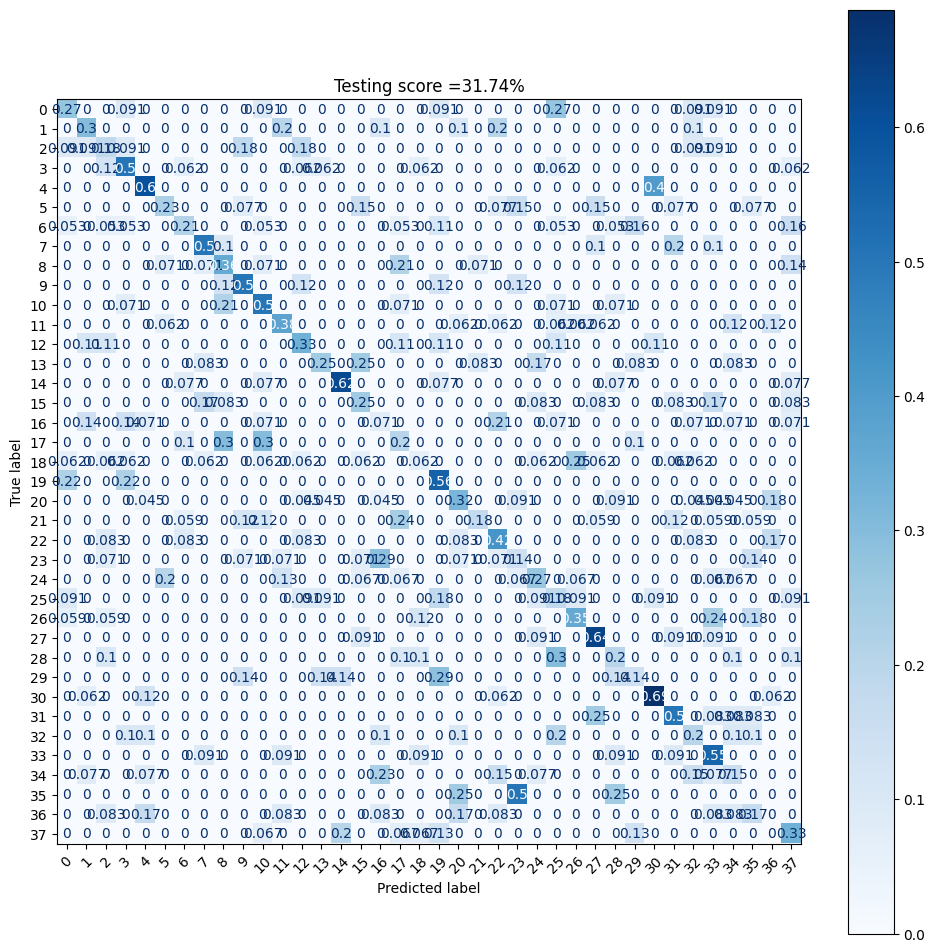

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12,12))
score = 100*clf_MLP.score(X_test_pca, y_test)
title = 'Testing score ={:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
clf_MLP,
X_test_pca,
y_test,
xticks_rotation=45, #’vertical’,
# display_labels=class_names,
cmap=plt.cm.Blues,
normalize='true',
ax = ax
)
disp.ax_.set_title(title)
plt.show()

<解釋混淆矩陣概念>

混淆矩陣（Confusion Matrix）是一種用於評估分類模型性能的表格，特別是在多類分類問題中。它以矩陣的形式顯示了模型在測試集上的預測結果與真實標籤之間的對應關係。

混淆矩陣的結構如下：

```
             Predicted Class 1   Predicted Class 2   ...   Predicted Class N
Actual Class 1      True Positive         False Negative   ...   False Negative
Actual Class 2      False Positive        True Positive    ...   False Negative
   ...                 ...                   ...            ...        ...
Actual Class N      False Positive       False Positive   ...    True Positive
```

在混淆矩陣中，行代表真實標籤，列代表模型預測的結果。其中每個元素的含義如下：

- True Positive（TP）：真實為正類（Actual Class）且被模型預測為正類（Predicted Class）的樣本數。
- False Positive（FP）：真實為負類且被模型錯誤地預測為正類的樣本數。
- True Negative（TN）：真實為負類且被模型預測為負類的樣本數。
- False Negative（FN）：真實為正類且被模型錯誤地預測為負類的樣本數。

通過混淆矩陣，可以清晰地了解模型在每個類別上的預測表現，進而計算出各種評估指標，例如精確率（Precision）、召回率（Recall）和 F1 分數（F1 Score）等，以更全面地評估模型的性能。

在這段程式碼中，使用 `ConfusionMatrixDisplay.from_estimator` 函數從已擬合的 `clf_MLP` 模型生成混淆矩陣的可視化表示，並將其顯示在圖形中。